# Why predict Broadway sales?
The main reasons we chose this data science problem were access to lots of relatively clean data on Broadway sale via the [Playbill](https://playbill.com/grosses) website combined with our shared interest in trying our hands at time series models.

However, this is not an entirely contrived data science problem; it actually resembles the type of problems real stakeholders in the show business industry might ask data scientists to solve. For example, about 80% of the 41 theaters considered to be "on Broadway" are owned by 3 groups (see chart below). These groups have significant resources to allocate and how they decide to do so is an expensive question for them. It is plausible they are willing to expend a small amount of those resources to ensure they allocate large amounts in a prudent manner.

![Broadway Owners](https://drive.google.com/uc?id=1yqvLg8S7xjKlcfJpWY7IcCO8rXeLswlb)

Comglomerates like these have an interest in accurate predictions of not just their annual box office gross for the coming year, but also how it is likely to fluctuate week-to-week, so they can budget accordingly. For example, if their cashflow is likely to plummet in a particular week, they want to anticipate this in order to keep enough cash on hand to maintain normal operations (e.g. making payroll). Alternatively, if they can anticipate high sales in a coming week, they can make arrangements for how to spend that money so it put to good use as quickly as possible (e.g. paying off a loan).

Further, while the models we build here predict gross sales, the Playbill data includes other potential outcome variables that could be of interest that could be easily predicted using similar models. For example, accurate predictions for the percent theater capacity sold week-to-week could also be useful information for theater-owners so they can plan renovations/facility maintenance and decrease staffing during emptier weeks. Average ticket price in a given week could help them set prices in anticipation of demand, given that many customers buy their tickets well in advance of the show, so demand gradually builds and prices cannot be set reactively.

# Our Approach

While most Broadway theaters are owned by conglomerates, it's probable that they maintain largely independent budgeting processes. Further, each theater has distinct characteristics that can affect its appeal to consumers (e.g. location relative to tourist traffic, seating capacity, architectural style, reputation, etc.) This, in turn, might affect how theater conglomerates choose to assign shows to theaters. For example, if a conglomerate anticipates a show will perform well (maybe because it has an all-star cast or is based on popular IP, etc.), they will probably assign it to one of their "better" theaters, especially one with a higher capacity or that typically sells more expensive tickets, in order to maximize the revenue it generates. This means that each theater likely has a slightly different pattern in its sales data. Thus, it is appropriate for us to build separate models to predict each theater individually.

For practical purposes, we chose to focus on the Gershwin and Majestic Theatres because their data contained the least numbers of missing values. Later in this notebook, we examine the sales data and find that there is significant variation from week-to-week. This can make imputation of an excessive number of missing values using most conventional techniques (e.g. backilling) problematic because it could deflate/inflate the amount of variation in the data and decrease the predictiveness of the model. However, we were not comfortable excluding the missing data as we did not know enough about the data generating process (DGP) to be sure that it wasn't missing for a reason that could affect the target variable (for example, maybe some low sales weeks were not reported to Playbill). Thus, exclusion might introduce bias into the models. Further, some of the models used here would not run properly with excluded data. Lastly, the Gershwin and Majestic are owned by separate conglomerates, so if there is some difference in the sales patterns between them for that reason, we can test if our model performs better on one more than another.

In each of these 3 notebooks, we build, tune, and test a different one of the most popular time series models in data science: Facebook's Prophet model, the autoregressive (AR) model, and the Seasonal Autoregressive Integrated Moving Average (SARIMA) model. Our goal is to build the best version that we can of each model and then compare their performance's to decide which one to adopt as "our" model (i.e. the one we would use to make actual out-of-sample predictions for a client). We decided to use multiple diagnostic metrics to determine the best-performing model, including the root mean-squared error (RMSE), the mean absolute error (MAE), and the mean absolute percent error (MAPE), which each have attributes that make them uniquely useful in measuring model performance. The RMSE has the feature of penalizing larger errors in prediction. This has real-world applicability because larger errors will have more significant financial consequences for our stakeholders. The MAE, by contrast, does not penalize larger errors, so it is a more true reflection of the general accuracy of the predictions. While the RMSE and MAE are both measured in the units of the target variable, interpreting these quantities can be difficult without a sense of the scale on which the target variable is measured. For example, an RMSE of 10 units is interpreted very differently if the average value of an observation is 1 unit or if it's 100 units. Thus, the MAPE is included to relate the size of the MAE to the values of the observations and is standardized as a percent.

# Forecasting Gross Broadway Sales using Facebook Prophet

Our goal in this notebook is to use Facebook Prophet to build a model that will predict the gross sales for a particular theater; in this case, Gershwin Theater. We will not perform any tuning of the model in this notebook; for this we refer to the notebook "Prophet_model_Gershwin_theatre_holidays_and_cv.ipynb".

The notebook is organized into the following sections:

1. Setup, where we import packages and the raw data.

2. Creating a DataFrame to feed to Prophet, where we extract the data on weekly gross sales for the Gershwin theatre.

3. Building a model, where we fit a Prophet model to the DataFrame.

4. Diagnostics, where we evaluate the model using Mean Absolute Error, Root Mean Squared Error, and Mean Absolute Percentage Error.


## Setup

Let us first import the packages we need. This will not run on your computer without the `prophet` package installed, but the output of the code blocks should still be visible.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

sns.set_style("whitegrid")

Next, we read in the data file `grosses.csv`.

In [9]:
df_raw = pd.read_csv('../DATA-COLLECTION/grosses.csv')
df_raw.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0


Next, we perform a bit of exploration to see if there's anything odd about the data.

In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47524 entries, 0 to 47523
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   week_ending           47524 non-null  object 
 1   week_number           47524 non-null  int64  
 2   weekly_gross_overall  47524 non-null  float64
 3   show                  47524 non-null  object 
 4   theatre               47524 non-null  object 
 5   weekly_gross          47524 non-null  float64
 6   potential_gross       34911 non-null  float64
 7   avg_ticket_price      47524 non-null  float64
 8   top_ticket_price      36167 non-null  float64
 9   seats_sold            47524 non-null  int64  
 10  seats_in_theatre      47524 non-null  int64  
 11  pct_capacity          47524 non-null  float64
 12  performances          47524 non-null  int64  
 13  previews              47524 non-null  int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 5.1+ MB


The columns we're interested in are `week_ending`, `theatre`, and `weekly_gross`. Happily, none of these columns have null values.

Let's also get some simple stats to get an idea of the numbers we're working with.

In [11]:
df_raw.describe()

,week_number,weekly_gross_overall,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
count,47524.000000,4.752400e+04,4.752400e+04,3.491100e+04,47524.000000,36167.000000,47524.000000,47524.000000,47524.000000,47524.000000,47524.000000
mean,27.372170,1.669303e+07,5.744868e+05,9.395982e+05,67.914736,189.681892,7893.449668,1237.793536,0.802753,7.237754,0.583663
std,15.310139,9.520198e+06,4.433470e+05,4.193233e+05,38.589416,112.304515,3186.019908,358.357398,0.176418,2.229733,1.926202
min,1.000000,2.474396e+06,0.000000e+00,7.754000e+03,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,9.093031e+06,2.622292e+05,6.295230e+05,43.370000,85.000000,5442.000000,1021.000000,0.691400,8.000000,0.000000
50%,28.000000,1.506067e+07,4.700645e+05,9.031500e+05,60.235000,200.000000,7736.000000,1181.000000,0.833000,8.000000,0.000000
75%,41.000000,2.289759e+07,7.584381e+05,1.190502e+06,84.652500,250.000000,10187.000000,1509.000000,0.953800,8.000000,0.000000
max,53.000000,5.780727e+07,4.041493e+06,3.559306e+06,511.580000,998.000000,24305.000000,1969.000000,1.553600,17.000000,16.000000


## Creating a DataFrame to feed to Prophet

Prophet requires a two-column DataFrame to build a model; the first column must be in `datetime` format, and the second column must be numerical. We need to manipulate `df_raw` to get the weekly grosses of Gershwin theater, indexed by the ending week.

First, let's extract all of the rows that have 'Gershwin Theater' in the `theatre` column.

In [12]:
df_raw['theatre'].unique()

array(['St. James Theatre', 'Sam S. Shubert Theatre',
       'Brooks Atkinson Theatre', 'Circle in the Square Theatre',
       'Lyceum Theatre', "Eugene O'Neill Theatre", 'Neil Simon Theatre',
       '46th Street Theatre', 'Winter Garden Theatre', 'Ritz Theatre',
       'Mark Hellinger Theatre', 'Palace Theatre', 'Ambassador Theatre',
       'Edison Theatre', 'Gershwin Theatre', 'Booth Theatre',
       'Broadway Theatre', 'Broadhurst Theatre', 'Minskoff Theatre',
       'Royale Theatre', 'Plymouth Theatre', 'Lunt-Fontanne Theatre',
       'Helen Hayes Theatre', 'Biltmore Theatre', 'Imperial Theatre',
       'John Golden Theatre', 'Music Box Theatre', 'Nederlander Theatre',
       'Ethel Barrymore Theatre', 'Longacre Theatre', 'Virginia Theatre',
       'Jack Lawrence Theatre', 'Vivian Beaumont Theater',
       'Marquis Theatre', 'Cort Theatre', 'Martin Beck Theatre',
       'Majestic Theatre', 'Criterion Center Stage Right',
       'Belasco Theatre', 'Richard Rodgers Theatre',
       '

In [13]:
df_gershwin = df_raw[df_raw['theatre'] == 'Gershwin Theatre']

Next, let's drop all columns except for `week_ending` and `weekly_gross`.

In [14]:
df_week_gross_series = df_gershwin[['week_ending', 'weekly_gross']]

And convert the `week_ending` column from string to `datetime` format.

In [15]:
df_week_gross_series['week_ending'] = pd.to_datetime(df_week_gross_series['week_ending'])

<ipython-input-15-c999bfa3789d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week_gross_series['week_ending'] = pd.to_datetime(df_week_gross_series['week_ending'])


Also, Prophet has the requirement that the two columns must be titled 'ds' and 'y', so let's rename them.

In [16]:
df_week_gross_series = df_week_gross_series.rename(columns={'week_ending': 'ds', 'weekly_gross': 'y'})

Next, we extract all rows between the dates 2013-06-02 and 2018-05-27, and preview the final DataFrame. This will serve as our training data. We decided to use only a subset of the data available to us to train our models for a few reasons. The practical reason was that more data is more unwieldy to explore and computationally expensive to train on. The theoretical reason is that sales over an extended period of time are likely to be affected by economic factors, like inflation and recessions, which are outside the scope of the current project. Lastly, data scientists are often asked to create high-performing models despite having limited data available to them, so we wanted to recreate that challenge for ourselves. However, because the majority of the signal in the data is contained in the patterns that repeat on an annual basis, we chose to make it easier on ourselves by at least including several years' worth of data.

In [21]:
from datetime import datetime

train_start_date = datetime.strptime('2013-06-02', '%Y-%m-%d')
train_end_date = datetime.strptime('2018-05-27', '%Y-%m-%d')

test_start_date = datetime.strptime('2018-06-03', '%Y-%m-%d')
test_end_date = datetime.strptime('2019-05-26', '%Y-%m-%d')

df_full = df_week_gross_series.loc[(df_week_gross_series.ds >= train_start_date) & (df_week_gross_series.ds <= test_end_date)].reset_index(drop = True)
df_train = df_full.loc[df_full.ds <= train_end_date]
df_test = df_full.loc[df_full.ds >= test_start_date]

Let's plot the evolution of the training data and the test data over time, to see how it looks.

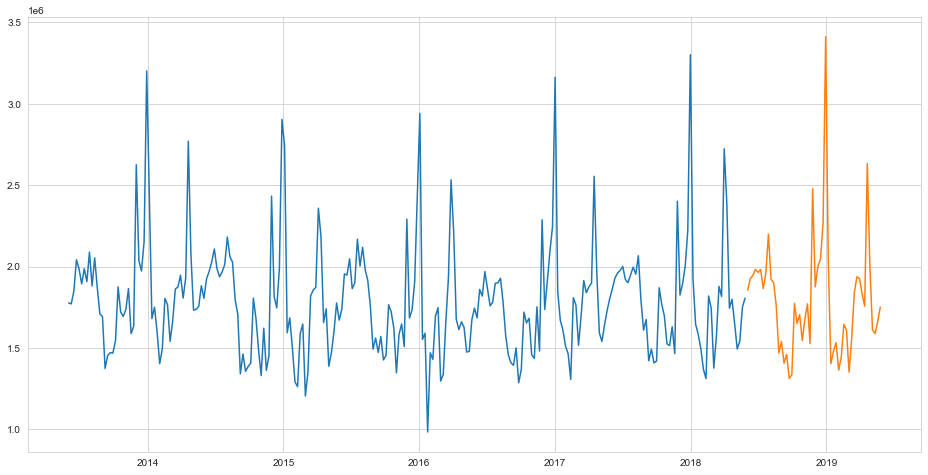

In [22]:
plt.figure(figsize=(16,8))
plt.plot(df_train['ds'], df_train['y'])
plt.plot(df_test['ds'], df_test['y'])

## Building a model

We call Prophet and fit it to our DataFrame `df_train`.

In [23]:
m = Prophet()
m.fit(df_train)

12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing


Next, we fill out the date column with 52 weeks into the future.

In [24]:
future = m.make_future_dataframe(periods = 52, freq = 'W')
future.tail()

,ds
307,2019-04-28
308,2019-05-05
309,2019-05-12
310,2019-05-19
311,2019-05-26


Then we call the `predict` method on `future`, to get predictions $\hat y$.

In [25]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-06-02,1.883982e+06,1.615245e+06,2.162539e+06
1,2013-06-09,1.902847e+06,1.648062e+06,2.160971e+06
2,2013-06-16,1.949264e+06,1.676006e+06,2.217452e+06
3,2013-06-23,2.023873e+06,1.782315e+06,2.270635e+06
4,2013-06-30,2.058809e+06,1.805255e+06,2.335369e+06


## Diagnostics

Next, we want to evaluate how well the model did. We add the actual values $y_t$ and the errors $|y_t-\hat y_t|$ to the `forecast` Data Frame.

In [26]:
forecast['actuals'] = df_full['y']
forecast['error'] = np.abs(forecast['actuals'] - forecast['yhat'])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'actuals', 'error']].head(10)

,ds,yhat,yhat_lower,yhat_upper,actuals,error
0,2013-06-02,1.883982e+06,1.615245e+06,2.162539e+06,1776282.0,107699.608353
1,2013-06-09,1.902847e+06,1.648062e+06,2.160971e+06,1770507.0,132339.503348
2,2013-06-16,1.949264e+06,1.676006e+06,2.217452e+06,1849045.0,100219.242572
3,2013-06-23,2.023873e+06,1.782315e+06,2.270635e+06,2041391.0,17518.279043
4,2013-06-30,2.058809e+06,1.805255e+06,2.335369e+06,1985154.0,73654.995360
5,2013-07-07,2.014850e+06,1.781131e+06,2.265501e+06,1893488.0,121362.496776
6,2013-07-14,1.951369e+06,1.696824e+06,2.205832e+06,1986489.0,35120.380935
7,2013-07-21,1.963496e+06,1.699494e+06,2.219728e+06,1907228.0,56268.179982
8,2013-07-28,2.056578e+06,1.807401e+06,2.285948e+06,2088425.0,31846.556180
9,2013-08-04,2.121491e+06,1.851802e+06,2.371629e+06,1880559.0,240932.069054


Next we compute the errors on the test data to get an idea of how far off the predictions are.

In [27]:
n = df_test.index.values.astype(int)[0] #This is the index where the test data starts in df_full

test_errors = forecast['error'][n:]
rmse = np.sqrt(1/len(test_errors)*np.sum(test_errors**2))
mae = 1/len(test_errors)*np.sum(test_errors)
mape= 1/len(test_errors)*sum(test_errors/forecast['actuals'][n:])

print('The Root Mean Squared Error on the test data is $' + str(round(rmse, 2)) + '.')
print('The Mean Absolute Error on the test data is $' + str(round(mae, 2))+'.')
print('The Mean Absolute Percent Error on the test data is '+str(round(mape*100,2))+'%.')

The Root Mean Squared Error of the test data is $228755.83.
The Mean Absolute Error of the test data is $153549.68.
The Mean Absolute Percent Error of the test data is 8.24%.


Below we plot the actual values against the predicted values, and plot the error below these two curves. The red dotted line indicates the separation between the train data and the test data (the model was trained only on the blue curve to the left of the red dotted line).

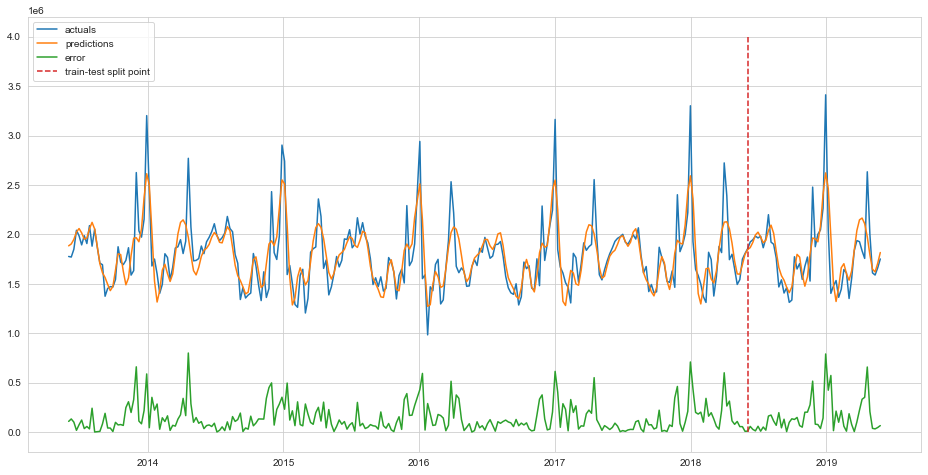

In [29]:
plt.figure(figsize=(16,8))
plt.plot(forecast['ds'], forecast['actuals'], label = 'actuals')
plt.plot(forecast['ds'], forecast['yhat'], label = 'predictions')
plt.plot(forecast['ds'], forecast['error'], label = 'error')
plt.plot([test_start_date, test_start_date], [0, 4000000], linestyle = '--', label = 'train-test split point')
plt.legend(loc = 'upper left')

Though it appears that the model did an okay job of capturing yearly seasonality, we can see that the errors tend to peak when the actual values peak. This is likely because Prophet assumes that such large values are outliers, but on closer inspection, these peaks occur shortly after holidays (Christmas, Thanksgiving, and Easter).

In the next notebook, we account for these points, and also perform cross-validation to see if we can lower the errors.